In [1]:
import scipy.io
import scipy.misc
import tensorflow as tf
import numpy as np
import time
from IPython.display import Image

In [10]:
data = scipy.io.loadmat('./imagenet-vgg-verydeep-19.mat')

image_content = scipy.misc.imread('./images/pebbles.jpg')
image_content = image_content.astype('float32')
image_content = np.ndarray.reshape(image_content,((1,) + image_content.shape)) # 1 means batch_size
#image_content = np.ndarray.reshape(image_content.shape + (1,)) it is needed to handle gray scale image 

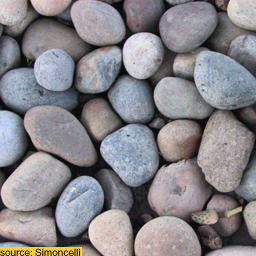

In [11]:
# content image
Image(filename = './images/pebbles.jpg')

In [12]:
def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)

def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

def preprocess(image, mean_pixel):
    return (image - mean_pixel).astype('float32')

def unprocess(image, mean_pixel):
    return (image + mean_pixel).astype('float32')

In [44]:
def net(input_image):
    layers = (
        'pool4', 'pool3', 'pool2', 'pool1', 'conv1_1'
#         'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

#         'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

#         'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
#         'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

#         'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
#         'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

#         'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
#         'relu5_3', 'conv5_4', 'relu5_4'
    )
    weight = data['layers'][0]
    net = {}
    current = input_image
    
    for i in range(10):
        print(i, weight[i])
    
#     for i, name in enumerate(layers):
#         kind = name[:4]
#         if kind == 'conv':
#             print(i, name, weight[i])
#             kernels, bias = weight[i][0][0][0][0]
#             # matconvnet: weights are [width, height, in_channels, out_channels]
#             # tensorflow: weights are [height, width, in_channels, out_channels]
#             kernels = np.transpose(kernels, (1, 0, 2, 3))
#             bias = bias.reshape(-1)
#             current = _conv_layer(current, kernels, bias)
#         elif kind == 'relu':
#             current = tf.nn.relu(current)
#         elif kind == 'pool':
#             current = _pool_layer(current)
#         net[name] = current

    assert len(net) == len(layers)
    return net#, mean_pixel

In [45]:
mean = data['normalization'][0][0][0]
mean_pixel = np.mean(mean, axis=(0, 1))

In [46]:
CONTENT_LAYERS = ('pool4', 'pool3', 'pool2', 'pool1', 'conv1_1')
content_features = {}

with tf.Session() as sess:
    content_pre = preprocess(image_content, mean_pixel)
    content_net = net(content_pre)
    for layer in CONTENT_LAYERS:
        content_features[layer] = content_net[layer].eval()

0 [[ (array([[ array([[[[ 0.39416704, -0.08419707, -0.03631314, ..., -0.10720515,
          -0.03804016,  0.04690642],
         [ 0.46418372,  0.03355668,  0.10245045, ..., -0.06945956,
          -0.04020201,  0.04048637],
         [ 0.34119523,  0.09563112,  0.0177449 , ..., -0.11436455,
          -0.05099866, -0.00299793]],

        [[ 0.37740308, -0.07876257, -0.04775979, ..., -0.11827433,
          -0.19008617, -0.01889699],
         [ 0.41810837,  0.05260524,  0.09755926, ..., -0.09385028,
          -0.20492788, -0.0573062 ],
         [ 0.33999205,  0.13363543,  0.02129423, ..., -0.13025227,
          -0.16508926, -0.06969624]],

        [[-0.04594866, -0.11583115, -0.14462094, ..., -0.12290562,
          -0.35782176, -0.27979308],
         [-0.04806903, -0.00658076, -0.02234544, ..., -0.0878844 ,
          -0.3915486 , -0.34632796],
         [-0.04484424,  0.06471398, -0.07631404, ..., -0.12629718,
          -0.29905206, -0.28253639]]],


       [[[ 0.2671299 , -0.07969447,  0.05

AssertionError: 

In [11]:
noise = np.random.normal(size=image_content.shape, scale=np.std(image_content) * 0.1)
initial = tf.random_normal(image_content.shape) * 0.256

In [12]:
image = tf.Variable(initial)
image_net = net(image)

In [13]:
content_weight = 5e0
style_weight = 1e4
tv_weight = 1e3
learning_rate = 1e0
iterations =  10000
checkpoint_iterations = 1000
print_iterations = 500

In [14]:
# content loss
# content_loss = content_weight * (2 * tf.nn.l2_loss(
#         image_net[CONTENT_LAYER] - content_features[CONTENT_LAYER]) / 
#         content_features[CONTENT_LAYER].size)
content_loss = 0
content_losses = []
for content_layer in CONTENT_LAYERS:
    content_losses.append(2 * tf.nn.l2_loss(
                          image_net[content_layer] - content_features[content_layer]) / 
                          content_features[content_layer].size)
content_loss += content_weight * tf.reduce_sum(content_losses)

In [15]:
# style loss
style_loss = 0
style_losses = []
for style_layer in STYLE_LAYERS:
    layer = image_net[style_layer]
    _, height, width, number = map(lambda i: i.value, layer.get_shape())
    size = height * width * number
    feats = tf.reshape(layer, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats) / size
    style_gram = style_features[style_layer]
    style_losses.append(2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
style_loss += style_weight * tf.reduce_sum(style_losses)

In [16]:
def _tensor_size(tensor):
    return tf.cast(tf.reduce_prod(tensor.get_shape()), tf.float32)

In [17]:
# total variation denoising
#print()
tv_y_size = _tensor_size(image[:,1:,:,:])
tv_x_size = _tensor_size(image[:,:,1:,:])
tv_loss = tv_weight * 2 * (
        (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:image_content.shape[1]-1,:,:]) /
            tv_y_size) +
        (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:image_content.shape[2]-1,:]) /
            tv_x_size))

In [18]:
# overall loss
loss = content_loss + style_loss + tv_loss

In [19]:
# optimizer setup
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [ ]:
def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)

In [ ]:
# optimization
best_loss = float('inf')
best = None

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(iterations):
        train_step.run()

        if i % checkpoint_iterations == 0 or i == iterations - 1:
            this_loss = loss.eval()
            if this_loss < best_loss:
                best_loss = this_loss
                best = image.eval()
            # save a check point
            import os
            try:
                os.makedirs('./checks/'+str.split(content_file_name,'.')[0])
            except OSError:
                pass
            timestr = time.strftime("%Y%m%d_%H%M%S")
            filename_cp = './checks/'+str.split(content_file_name,'.')[0]+'/'+timestr+'.jpg'
            cp = unprocess(best.reshape(image_content.shape[1:]), mean_pixel)
            imsave(filename_cp, cp)

        if i % print_iterations == 0 or i == iterations - 1:
            print('Iteration %d/%d' % (i + 1, iterations))
            print('  content loss: %g' % content_loss.eval())
            print('    style loss: %g' % style_loss.eval())
            print('       tv loss: %g' % tv_loss.eval())
            print('    total loss: %g' % loss.eval())

    output = unprocess(best.reshape(image_content.shape[1:]), mean_pixel)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iteration 1/10000
  content loss: 2.39741e+07
    style loss: 3.51792e+09
       tv loss: 2803.47
    total loss: 3.54189e+09


In [ ]:
imsave('./images/output_'+content_file_name, output)

In [ ]:
Image(filename = './images/output_'+content_file_name)